In [1]:
import pandas as pd
import sys
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt
import os

# Precinct Shapefile

## VEST's Documentation File

Election results from Kansas Secretary of State (https://sos.kansas.gov/elections/election-statistics/) with gaps filled by OpenElections (http://openelections.net/) via county sources.
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release.

Shapefiles from county elections officials used in Geary, Johnson, and Riley Counties.

Modifications needed to be made to reflect differences between Census shapefiles and actual PDF maps or reported results.

- Barber: Ridge merged into Sharon Township
- Butler: Augusta Township merged
- Chase: East/West Strong merged, East/West Falls merged
- Cherokee: Treece merged with township
- Clay: Altered Clay Center boundaries based on PDF map
- Cowley: Merge East/West Bolton
- Douglas: Altered based on PDF map
- Ellis: Split two precincts based on state house districts
- Franklin: Merged Ottawa 4+5, altered boundary between 1 and 2
- Hamilton: Adjusted Syracuse boundaries based on voter file
- Harvey: Distributed an exclave district to its neighboring townships
- Labette: Split precincts based on legislative districts
- Leavenworth: Merged legislative district-split precincts that don't appear in results
- Lyon: Mergers based on PDF map
- Meade: Split Louisburg based on PDF map
- Osborne: Merged some cities into surrounding townships, split Ross based on information from personal communication with county election official
- Reno: Merged based on PDF map
- Shawnee: Merged wards in Topeka to match result reporting
- Stevens: Cut Moscow City out of Township using Census place shapefile, recut Hugoton based on PDF map
- Sumner: Split precincts based on legislative district lines


- G18GOVDKEL - Laura Kelly (Democratic Party)
- G18GOVRKOB - Kris Kobach (Republican Party)
- G18GOVIORM - Greg Orman (Independent)
- G18GOVLCAL - Jeff Caldwell (Libertarian Party)
- G18GOVIKLO - Rick Kloos (Independent)


- G18SOSRSCH - Scott Schwab (Republican Party)
- G18SOSDMCC - Brian "BAM" McClendon (Democratic Party)
- G18SOSLHOD - Rob Hodgkinson (Libertarian Party)


- G18ATGRSCH - Derek Schmidt (Republican Party)
- G18ATGDSWA - Sarah G. Swain (Democratic Party)


- G18INSDMCL - Nathaniel McLaughlin (Democratic Party)
- G18INSRSCH - Vicki Schmidt (Republican Party)


- G18TRERLAT - Jake LaTurner (Republican Party)
- G18TREDFRA - Marci Francisco (Democratic Party)


## Load VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/ks_2018/ks_2018.shp")

In [3]:
vest_shp.shape

(4059, 18)

In [4]:
vest_shp.head(1)

,COUNTYFP,VTDST,NAMELSAD,G18GOVDKEL,G18GOVRKOB,G18GOVIORM,G18GOVLCAL,G18GOVIKLO,G18SOSRSCH,G18SOSDMCC,G18SOSLHOD,G18ATGRSCH,G18ATGDSWA,G18INSDMCL,G18INSRSCH,G18TRERLAT,G18TREDFRA,geometry
0,001,000010,Carlyle Township Voting District,48,98,5,3,4,116,35,5,125,31,27,122,115,37,"POLYGON Z ((-95.42748 37.96487 0.00000, -95.42..."


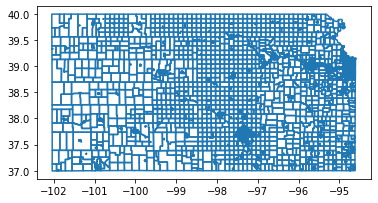

In [5]:
vest_shp.boundary.plot()

# Loading, Combining Election Results

## Load County Fips File

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Kansas"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
fips_dict = dict(zip(fips_file["County Name"].str.lower(),fips_file["FIPS County"]))

## Election Results

### Minor Counties

The `2018_General_Election_Precinct_Level_Results.xlsx` file was created by manually combining tabs in Excel that were separated out for each office. 

In [7]:
results = pd.ExcelFile('./raw-from-source/SOS/2018_General_Election_Precinct_Level_Results.xlsx')

minor_counties_df = pd.read_excel(results, 'Results')
minor_counties_df = minor_counties_df.pivot_table(index = ['County','Precinct','VTD'],
                         columns = ['Race','Candidate'],
                        values = ['Votes'],
                         aggfunc = 'sum')
minor_counties_df.reset_index(inplace=True)
minor_counties_df = minor_counties_df[~minor_counties_df['County'].isin(['JOHNSON','SEDGWICK','SHAWNEE','WYANDOTTE'])]
minor_counties_df.head(1)

County          Precinct     VTD            Votes                   \
Race                                       Attorney General                    
Candidate                                  Schmidt, Derek   Swain, Sarah G.    
0          ALLEN  Carlyle Township  000010            125.0             31.0   

                                                                              \
Race      Commissioner of Insurance                  Governor / Lt. Governor   
Candidate   McLaughlin, Nathaniel   Schmidt, Vicki          Caldwell, Jeff     
0                              27.0            122.0                     3.0   

                                                                     \
Race                                                                  
Candidate Kelly, Laura   Kloos, Rick   Kobach, Kris   Orman, Greg     
0                   48.0           4.0           98.0           5.0   

                                                                      \
Race      Secretary of State                                           
Candidate  Hodgkinson, Rob   McClendon, Brian "BAM"  Schwab, Scott     
0                        5.0                    35.0           116.0   

                                               
Race         State Treasurer                   
Candidate Francisco, Marci   LaTurner, Jake    
0                       37.0            115.0

In [8]:
minor_counties_df.columns = ['county','precinct','vtd','G18ATGRSCH', 'G18ATGDSWA','G18INSDMCL', 'G18INSRSCH',
                            'G18GOVLCAL', 'G18GOVDKEL','G18GOVIKLO', 'G18GOVRKOB', 'G18GOVIORM', 
                            'G18SOSLHOD','G18SOSDMCC', 'G18SOSRSCH','G18TREDFRA', 'G18TRERLAT']
minor_counties_df.head(5)

,county,precinct,vtd,G18ATGRSCH,G18ATGDSWA,G18INSDMCL,G18INSRSCH,G18GOVLCAL,G18GOVDKEL,G18GOVIKLO,G18GOVRKOB,G18GOVIORM,G18SOSLHOD,G18SOSDMCC,G18SOSRSCH,G18TREDFRA,G18TRERLAT
0,ALLEN,Carlyle Township,000010,125.0,31.0,27.0,122.0,3.0,48.0,4.0,98.0,5.0,5.0,35.0,116.0,37.0,115.0
1,ALLEN,Cottage Grove Township,000020,76.0,23.0,23.0,77.0,2.0,40.0,0.0,57.0,2.0,4.0,26.0,67.0,30.0,69.0
2,ALLEN,Deer Creek Township,000030,40.0,8.0,11.0,37.0,2.0,15.0,2.0,27.0,2.0,3.0,8.0,35.0,14.0,33.0
3,ALLEN,East Elm,000040,153.0,42.0,43.0,147.0,12.0,58.0,4.0,113.0,10.0,8.0,50.0,133.0,50.0,141.0
4,ALLEN,Geneva Township,000050,43.0,10.0,8.0,45.0,1.0,13.0,0.0,38.0,1.0,2.0,11.0,40.0,12.0,41.0


In [9]:
cols = [x for x in vest_shp.columns if 'G18' in x]
minor_counties_df[cols] = minor_counties_df[cols].apply(pd.to_numeric) 

### Johnson

In [10]:
johnson_df = pd.read_excel(results, 'JOHNSON')
johnson_df.head()

,PRECINCT CODE,PRECINCT NAME,G18GOVLCAL,G18GOVDKEL,G18GOVIKLO,G18GOVRKOB,G18GOVIORM,G18ATGRSCH,G18ATGDSWA,G18TREDFRA,G18TRERLAT,G18INSDMCL,G18INSRSCH,G18SOSLHOD,G18SOSDMCC,G18SOSRSCH
0,1,Aubry Township Precinct 01,3,39,1,76,4,85,38,39,85,34,88,23,31,70
1,2,Aubry Township Precinct 02,12,306,4,441,38,521,268,276,512,238,543,80,249,469
2,3,Aubry Township Precinct 03,8,156,1,227,29,264,149,142,269,132,275,38,146,238
3,4,Aubry Township Precinct 04,29,380,2,567,58,677,351,357,666,326,673,150,282,598
4,5,Aubry Township Precinct 05,0,10,0,8,1,11,7,6,12,6,12,1,6,11


In [12]:
johnson_df['county'] = 'Johnson'
johnson_df.rename(columns={'PRECINCT CODE':'vtd','PRECINCT NAME':'precinct'}, inplace = True)    

In [13]:
cols = [x for x in vest_shp.columns if 'G18' in x]
for c in cols: 
    johnson_df[c] = johnson_df[c].astype(float)
johnson_df.dtypes

vtd             int64
precinct       object
G18GOVLCAL    float64
G18GOVDKEL    float64
G18GOVIKLO    float64
G18GOVRKOB    float64
G18GOVIORM    float64
G18ATGRSCH    float64
G18ATGDSWA    float64
G18TREDFRA    float64
G18TRERLAT    float64
G18INSDMCL    float64
G18INSRSCH    float64
G18SOSLHOD    float64
G18SOSDMCC    float64
G18SOSRSCH    float64
county         object
dtype: object

### Sedgwick

In [14]:
sedgwick_df = pd.read_excel(results, 'SEDGWICK')
sedgwick_df = sedgwick_df.pivot_table(index = ['Precinct'],
                         columns = ['Candidate'],
                        values = ['Votes'],
                         aggfunc = 'sum')
sedgwick_df.reset_index(inplace=True)
sedgwick_df.head()

Precinct                 Votes                           \
Candidate          Brian "BAM" McClendon Derek Schmidt Greg Orman   
0              101                   449           377         52   
1              102                   406           441         48   
2              103                    95            50         10   
3              104                    34            15          2   
4              105                   360           161         32   

                                                                               \
Candidate Jake LaTurner Jeff Caldwell Kris Kobach Laura Kelly Marci Francisco   
0                   362            20         289         443             431   
1                   425             9         308         442             374   
2                    49             6          29          99              93   
3                    14             4          10          35              35   
4                   157             9         111         366             351   

                                                                         \
Candidate Nathaniel McLaughlin Rick Kloos Rob Hodgkinson Sarah G. Swain   
0                          403          6             25            417   
1                          325          6             35            357   
2                           84          0             11             90   
3                           31          0              1             36   
4                          328          4             25            351   

                                               
Candidate Scott Schwab Vicki Schmidt WRITE-IN  
0                  322           373        4  
1                  367           455        4  
2                   35            57        0  
3                   15            19        0  
4                  130           174        0

In [15]:
sedgwick_df.columns = ['precinct','G18SOSDMCC','G18ATGRSCH','G18GOVIORM', 'G18TRERLAT',
                       'G18GOVLCAL','G18GOVRKOB','G18GOVDKEL','G18TREDFRA','G18INSDMCL','G18GOVIKLO', 
                       'G18SOSLHOD','G18ATGDSWA','G18SOSRSCH','G18INSRSCH','wi']
sedgwick_df.head(5)

,precinct,G18SOSDMCC,G18ATGRSCH,G18GOVIORM,G18TRERLAT,G18GOVLCAL,G18GOVRKOB,G18GOVDKEL,G18TREDFRA,G18INSDMCL,G18GOVIKLO,G18SOSLHOD,G18ATGDSWA,G18SOSRSCH,G18INSRSCH,wi
0,101,449,377,52,362,20,289,443,431,403,6,25,417,322,373,4
1,102,406,441,48,425,9,308,442,374,325,6,35,357,367,455,4
2,103,95,50,10,49,6,29,99,93,84,0,11,90,35,57,0
3,104,34,15,2,14,4,10,35,35,31,0,1,36,15,19,0
4,105,360,161,32,157,9,111,366,351,328,4,25,351,130,174,0


In [16]:
sedgwick_df['county'] = 'Sedgwick'

In [17]:
cols = [x for x in vest_shp.columns if 'G18' in x]
for c in cols: 
    sedgwick_df[c] = sedgwick_df[c].astype(float)
sedgwick_df.dtypes

precinct       object
G18SOSDMCC    float64
G18ATGRSCH    float64
G18GOVIORM    float64
G18TRERLAT    float64
G18GOVLCAL    float64
G18GOVRKOB    float64
G18GOVDKEL    float64
G18TREDFRA    float64
G18INSDMCL    float64
G18GOVIKLO    float64
G18SOSLHOD    float64
G18ATGDSWA    float64
G18SOSRSCH    float64
G18INSRSCH    float64
wi              int64
county         object
dtype: object

### Shawnee

In [18]:
shawnee_df = pd.read_excel(results, 'SHAWNEE')
shawnee_df.head()

,PRECINCT NAME,G18GOVLCAL,G18GOVDKEL,G18GOVIKLO,G18GOVRKOB,G18GOVIORM,G18ATGRSCH,G18ATGDSWA,G18TREDFRA,G18TRERLAT,G18INSDMCL,G18INSRSCH,G18SOSLHOD,G18SOSDMCC,G18SOSRSCH
0,1 East Rossville,9,211,2,191,33,321,117,133,303,84,347,20,174,250
1,2 West Rossville,4,140,3,165,12,233,88,87,232,65,233,9,116,194
2,9 East Silver Lake,5,313,4,211,31,371,187,195,350,134,410,11,264,274
3,10 West Silver Lake,6,199,4,145,21,252,116,114,247,70,289,10,165,197
4,12 Grove,4,146,6,157,27,259,75,76,257,54,274,11,116,206


In [19]:
shawnee_df['county'] = 'Shawnee'
shawnee_df.rename(columns={'PRECINCT NAME':'precinct'}, inplace = True)

In [20]:
cols = [x for x in vest_shp.columns if 'G18' in x]
for c in cols: 
    shawnee_df[c] = shawnee_df[c].astype(float)
shawnee_df.dtypes

precinct       object
G18GOVLCAL    float64
G18GOVDKEL    float64
G18GOVIKLO    float64
G18GOVRKOB    float64
G18GOVIORM    float64
G18ATGRSCH    float64
G18ATGDSWA    float64
G18TREDFRA    float64
G18TRERLAT    float64
G18INSDMCL    float64
G18INSRSCH    float64
G18SOSLHOD    float64
G18SOSDMCC    float64
G18SOSRSCH    float64
county         object
dtype: object

### Wyandotte

We reached out to the KS SOS to receive the Wyandotte Precinct-Level Election results but have not heard back. We will use OpenElections results for Wyandotte county for this validation. 

In [21]:
wyandotte_df = pd.read_csv('./raw-from-source/OpenElections/20181106__ks__general__precinct.csv')
wyandotte_df = wyandotte_df[wyandotte_df['office'].isin(['Attorney General','Commissioner of Insurance','Secretary of State',
                                                        'Governor','State Treasurer'])]
wyandotte_df = wyandotte_df[wyandotte_df['county'] == 'Wyandotte']
wyandotte_df = wyandotte_df.pivot_table(index = ['county','precinct'],
                         columns = ['office','candidate'],
                        values = ['votes'],
                         aggfunc = 'sum')
wyandotte_df.reset_index(inplace=True)
display(wyandotte_df.head(5))
display(wyandotte_df.columns.to_list())

county            precinct            votes                 \
office                                   Attorney General                  
candidate                                   Derek Schmidt Sarah G. Swain   
0          Wyandotte  Bonner Springs 1-1              283            288   
1          Wyandotte  Bonner Springs 2-1              244            215   
2          Wyandotte  Bonner Springs 3-1              298            346   
3          Wyandotte  Bonner Springs 4-1              420            460   
4          Wyandotte        Delaware 1-1                9              5   

                                                                        \
office    Commissioner of Insurance                           Governor   
candidate      Nathaniel McLaughlin Vicki Schmidt Greg Orman John Doll   
0                               258           309                   25   
1                               187           264                   26   
2                               325           309                   40   
3                               427           441                   48   
4                                 5             9                    1   

                                                                               \
office                                                                          
candidate Jeff Caldwell Mary Kris Kobach Wink Hartman Laura Kelly Lynn Rogers   
0                         20                      232                     299   
1                         12                      205                     216   
2                         20                      233                     353   
3                         17                      326                     490   
4                          0                        9                       5   

                                                                           \
office                                  Secretary of State                  
candidate Rick Kloos Nathaniel Kloos Brian "BAM" McClendon Rob Hodgkinson   
0                                 11                   260             20   
1                                  5                   193             26   
2                                  8                   322             32   
3                                 12                   451             27   
4                                  0                     5              0   

                                                        
office                 State Treasurer                  
candidate Scott Schwab  Jake La Turner Marci Francisco  
0                  298             291             272  
1                  242             235             219  
2                  291             290             344  
3                  404             415             457  
4                    9               8               5

[('county', '', ''),
 ('precinct', '', ''),
 ('votes', 'Attorney General', 'Derek Schmidt'),
 ('votes', 'Attorney General', 'Sarah G. Swain'),
 ('votes', 'Commissioner of Insurance', 'Nathaniel McLaughlin'),
 ('votes', 'Commissioner of Insurance', 'Vicki Schmidt'),
 ('votes', 'Governor', 'Greg Orman John Doll'),
 ('votes', 'Governor', 'Jeff Caldwell Mary'),
 ('votes', 'Governor', 'Kris Kobach Wink Hartman'),
 ('votes', 'Governor', 'Laura Kelly Lynn Rogers'),
 ('votes', 'Governor', 'Rick Kloos Nathaniel Kloos'),
 ('votes', 'Secretary of State', 'Brian "BAM" McClendon'),
 ('votes', 'Secretary of State', 'Rob Hodgkinson'),
 ('votes', 'Secretary of State', 'Scott Schwab'),
 ('votes', 'State Treasurer', 'Jake La Turner'),
 ('votes', 'State Treasurer', 'Marci Francisco')]

In [22]:
wyandotte_df.columns = ['county','precinct',
                       'G18ATGRSCH','G18ATGDSWA','G18INSDMCL','G18INSRSCH',
                       'G18GOVIORM','G18GOVLCAL','G18GOVRKOB','G18GOVDKEL','G18GOVIKLO',
                       'G18SOSDMCC','G18SOSLHOD','G18SOSRSCH',
                       'G18TRERLAT','G18TREDFRA']
wyandotte_df.head()

,county,precinct,G18ATGRSCH,G18ATGDSWA,G18INSDMCL,G18INSRSCH,G18GOVIORM,G18GOVLCAL,G18GOVRKOB,G18GOVDKEL,G18GOVIKLO,G18SOSDMCC,G18SOSLHOD,G18SOSRSCH,G18TRERLAT,G18TREDFRA
0,Wyandotte,Bonner Springs 1-1,283,288,258,309,25,20,232,299,11,260,20,298,291,272
1,Wyandotte,Bonner Springs 2-1,244,215,187,264,26,12,205,216,5,193,26,242,235,219
2,Wyandotte,Bonner Springs 3-1,298,346,325,309,40,20,233,353,8,322,32,291,290,344
3,Wyandotte,Bonner Springs 4-1,420,460,427,441,48,17,326,490,12,451,27,404,415,457
4,Wyandotte,Delaware 1-1,9,5,5,9,1,0,9,5,0,5,0,9,8,5


In [23]:
cols = [x for x in vest_shp.columns if 'G18' in x]
for c in cols: 
    wyandotte_df[c] = wyandotte_df[c].astype(float)
wyandotte_df.dtypes

county         object
precinct       object
G18ATGRSCH    float64
G18ATGDSWA    float64
G18INSDMCL    float64
G18INSRSCH    float64
G18GOVIORM    float64
G18GOVLCAL    float64
G18GOVRKOB    float64
G18GOVDKEL    float64
G18GOVIKLO    float64
G18SOSDMCC    float64
G18SOSLHOD    float64
G18SOSRSCH    float64
G18TRERLAT    float64
G18TREDFRA    float64
dtype: object

### Combine Results

In [24]:
display(minor_counties_df.head(1))
display(johnson_df.head(1))
display(sedgwick_df.head(1))
display(shawnee_df.head(1))
display(wyandotte_df.head(1))

,county,precinct,vtd,G18ATGRSCH,G18ATGDSWA,G18INSDMCL,G18INSRSCH,G18GOVLCAL,G18GOVDKEL,G18GOVIKLO,G18GOVRKOB,G18GOVIORM,G18SOSLHOD,G18SOSDMCC,G18SOSRSCH,G18TREDFRA,G18TRERLAT
0,ALLEN,Carlyle Township,000010,125.0,31.0,27.0,122.0,3.0,48.0,4.0,98.0,5.0,5.0,35.0,116.0,37.0,115.0


,vtd,precinct,G18GOVLCAL,G18GOVDKEL,G18GOVIKLO,G18GOVRKOB,G18GOVIORM,G18ATGRSCH,G18ATGDSWA,G18TREDFRA,G18TRERLAT,G18INSDMCL,G18INSRSCH,G18SOSLHOD,G18SOSDMCC,G18SOSRSCH,county
0,1,Aubry Township Precinct 01,3.0,39.0,1.0,76.0,4.0,85.0,38.0,39.0,85.0,34.0,88.0,23.0,31.0,70.0,Johnson


,precinct,G18SOSDMCC,G18ATGRSCH,G18GOVIORM,G18TRERLAT,G18GOVLCAL,G18GOVRKOB,G18GOVDKEL,G18TREDFRA,G18INSDMCL,G18GOVIKLO,G18SOSLHOD,G18ATGDSWA,G18SOSRSCH,G18INSRSCH,wi,county
0,101,449.0,377.0,52.0,362.0,20.0,289.0,443.0,431.0,403.0,6.0,25.0,417.0,322.0,373.0,4,Sedgwick


,precinct,G18GOVLCAL,G18GOVDKEL,G18GOVIKLO,G18GOVRKOB,G18GOVIORM,G18ATGRSCH,G18ATGDSWA,G18TREDFRA,G18TRERLAT,G18INSDMCL,G18INSRSCH,G18SOSLHOD,G18SOSDMCC,G18SOSRSCH,county
0,1 East Rossville,9.0,211.0,2.0,191.0,33.0,321.0,117.0,133.0,303.0,84.0,347.0,20.0,174.0,250.0,Shawnee


,county,precinct,G18ATGRSCH,G18ATGDSWA,G18INSDMCL,G18INSRSCH,G18GOVIORM,G18GOVLCAL,G18GOVRKOB,G18GOVDKEL,G18GOVIKLO,G18SOSDMCC,G18SOSLHOD,G18SOSRSCH,G18TRERLAT,G18TREDFRA
0,Wyandotte,Bonner Springs 1-1,283.0,288.0,258.0,309.0,25.0,20.0,232.0,299.0,11.0,260.0,20.0,298.0,291.0,272.0


In [25]:
election_results = pd.concat([minor_counties_df, johnson_df, sedgwick_df, shawnee_df, wyandotte_df], ignore_index = True)

In [26]:
election_results.sample(5)

,county,precinct,vtd,G18ATGRSCH,G18ATGDSWA,G18INSDMCL,G18INSRSCH,G18GOVLCAL,G18GOVDKEL,G18GOVIKLO,G18GOVRKOB,G18GOVIORM,G18SOSLHOD,G18SOSDMCC,G18SOSRSCH,G18TREDFRA,G18TRERLAT,wi
968,FORD,Richland Township,000260,138.0,48.0,47.0,139.0,6.0,52.0,0.0,113.0,18.0,6.0,58.0,124.0,57.0,131.0,NaN
514,COWLEY,West Creswell Enclave C,900040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1977,OSBORNE,Delhi Township,000050,9.0,3.0,2.0,10.0,0.0,6.0,0.0,6.0,0.0,1.0,4.0,7.0,3.0,9.0,NaN
1089,GRAY,Cimarron Township Precinct 2,500020,543.0,120.0,118.0,528.0,7.0,149.0,3.0,404.0,108.0,22.0,153.0,484.0,125.0,533.0,NaN
30,ANDERSON,Garnett Precinct 2,000030,230.0,99.0,78.0,247.0,8.0,127.0,3.0,182.0,20.0,31.0,82.0,219.0,101.0,230.0,NaN


In [27]:
election_results['COUNTYFP'] = election_results['county'].str.lower().map(fips_dict)

In [28]:
election_results['COUNTYFP'].nunique()

105

In [29]:
election_results.shape

(3878, 19)

In [31]:
vest_shp.shape

(4059, 18)

# Validating Election Results

## Statewide

In [32]:
vest_shp.columns

Index(['COUNTYFP', 'VTDST', 'NAMELSAD', 'G18GOVDKEL', 'G18GOVRKOB',
       'G18GOVIORM', 'G18GOVLCAL', 'G18GOVIKLO', 'G18SOSRSCH', 'G18SOSDMCC',
       'G18SOSLHOD', 'G18ATGRSCH', 'G18ATGDSWA', 'G18INSDMCL', 'G18INSRSCH',
       'G18TRERLAT', 'G18TREDFRA', 'geometry'],
      dtype='object')

In [33]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))


data_columns = ['G18GOVDKEL', 'G18GOVRKOB',
       'G18GOVIORM', 'G18GOVLCAL', 'G18GOVIKLO', 'G18SOSRSCH', 'G18SOSDMCC',
       'G18SOSLHOD', 'G18ATGRSCH', 'G18ATGDSWA', 'G18INSDMCL', 'G18INSRSCH',
       'G18TRERLAT', 'G18TREDFRA']

statewide_totals_check(vest_shp, election_results, data_columns)


***Statewide Totals Check***
G18GOVDKEL is equal 	VEST / RDH: 506509
G18GOVRKOB is equal 	VEST / RDH: 453030
G18GOVIORM is equal 	VEST / RDH: 68498
G18GOVLCAL has a difference of 10.0 votes
	VEST: 20009 votes
	SOURCES: 19999.0 votes
G18GOVIKLO is equal 	VEST / RDH: 6576
G18SOSRSCH is equal 	VEST / RDH: 548708
G18SOSDMCC has a difference of 20.0 votes
	VEST: 457971 votes
	SOURCES: 457951.0 votes
G18SOSLHOD is equal 	VEST / RDH: 36847
G18ATGRSCH is equal 	VEST / RDH: 613644
G18ATGDSWA is equal 	VEST / RDH: 427169
G18INSDMCL is equal 	VEST / RDH: 380086
G18INSRSCH is equal 	VEST / RDH: 643487
G18TRERLAT has a difference of 1.0 votes
	VEST: 597614 votes
	SOURCES: 597613.0 votes
G18TREDFRA has a difference of -1.0 votes
	VEST: 437756 votes
	SOURCES: 437757.0 votes


VEST differs from OpenElections in Wyandotte county, and matches the SOS in all other counties. For these differences, we check against the Official Results from the KS SOS [here](https://www.sos.ks.gov/elections/18elec/2018_General_Election_Official_Votes_Cast.pdf). 

VEST is correct in ever place there is a discretion. 

## County-by-county

In [34]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

                    
county_totals_check(vest_shp,election_results,data_columns,'COUNTYFP')

***Countywide Totals Check***

G18GOVDKEL is equal across all counties
G18GOVRKOB is equal across all counties
G18GOVIORM is equal across all counties
G18GOVLCAL contains differences in these counties:
	209 has a difference of 10.0 votes
		VEST: 1320 votes
		SOURCES: 1310.0 votes
G18GOVIKLO is equal across all counties
G18SOSRSCH is equal across all counties
G18SOSDMCC contains differences in these counties:
	209 has a difference of 20.0 votes
		VEST: 27274 votes
		SOURCES: 27254.0 votes
G18SOSLHOD is equal across all counties
G18ATGRSCH is equal across all counties
G18ATGDSWA is equal across all counties
G18INSDMCL is equal across all counties
G18INSRSCH is equal across all counties
G18TRERLAT contains differences in these counties:
	209 has a difference of 1.0 votes
		VEST: 12647 votes
		SOURCES: 12646.0 votes
G18TREDFRA contains differences in these counties:
	209 has a difference of -1.0 votes
		VEST: 28362 votes
		SOURCES: 28363.0 votes


The KS SOS does not post the county level totals for Wyandotte county, however we know that VEST is correct in all instances because we checked the statewide totals above. 

## Precinct-by-precinct

VEST performed the following merges and splits of precincts in order to join the files: 
```
- Barber: Ridge merged into Sharon Township
- Butler: Augusta Township merged
- Chase: East/West Strong merged, East/West Falls merged
- Cherokee: Treece merged with township
- Clay: Altered Clay Center boundaries based on PDF map
- Cowley: Merge East/West Bolton
- Douglas: Altered based on PDF map
- Ellis: Split two precincts based on state house districts
- Franklin: Merged Ottawa 4+5, altered boundary between 1 and 2
- Hamilton: Adjusted Syracuse boundaries based on county commission district map
- Harvey: Distributed an exclave district to its neighboring townships
- Labette: Split precincts based on legislative districts
- Leavenworth: Merged legislative district-split precincts that don't appear in results
- Lyon: Mergers based on PDF map
- Meade: Split Louisburg based on PDF map
- Mitchell: Merged Beloit precincts based on county reports
- Osborne: Merged some cities into surrounding townships, split Ross based on information from personal communication with county election official
- Reno: Merged based on PDF map
- Shawnee: Merged wards in Topeka to match result reporting
- Stevens: Cut Moscow City out of Township using Census place shapefile, recut Hugoton based on PDF map
- Sumner: Split precincts based on legislative district lines
```

We are not going to validate the precinct by precinct election results at this time, as there is a difference of 4,059 precincts in the VEST file and 3,878 in the sos election results, and the county by county election results match. 